In [4]:
import urllib.request as url
import pandas as pd 
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

 For preprocessing of the factors and generation of the factorsReturns dataframe see factors-preprocessing.py <br>
 Importing the preprocessed dataframes of instrumentsReturns & factorsReturns

In [6]:
#%% Import dataframes

instrumentsReturns = pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/instruments_returns.csv")
instrumentsReturns = pd.DataFrame(instrumentsReturns)

factors_with_dates =  pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/factors_returns.csv")
factors_with_dates = pd.DataFrame(factors_with_dates)

factorsReturns = pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/factors_returns.csv")
factorsReturns = pd.DataFrame(factorsReturns)

factorsReturns["Date"] = pd.to_datetime(factorsReturns["Date"])
factors_with_dates["Date"] = pd.to_datetime(factors_with_dates["Date"])
instrumentsReturns["Date"] = pd.to_datetime(instrumentsReturns["Date"])

factorsReturns = factorsReturns.fillna(method='bfill')
factorsReturns = factorsReturns.fillna(method='ffill')

# Running the model on each instrument

1) Featurization : generate 3 features for each one of the 4 factors<br>
2) Align timeframes of factors with the specific instrument<br>
3) Run a linear regression based on features on a specific instrument & generate parameters


Featurization : generate 3 features for each one of the 4 factors

In [7]:
#%%
#Featurization of the factors

#Creation of a matrix of factors
Dates = pd.DataFrame(factorsReturns["Date"])
F1 = np.array(factorsReturns["f_GSP"])
F2 = np.array(factorsReturns["f_NDAQ"])
F3 = np.array(factorsReturns["f_OPEC"])
F4 = np.array(factorsReturns["f_TREASURY"])
factorsReturns = list((F1,F2,F3,F4))

def transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

def get_features(factorReturns):
    factorReturns = list(factorReturns)
    squaredReturns = [np.sign(element)*(element)**2 for element in factorReturns]
    squareRootedReturns = [np.sign(element)*abs(element)**0.5 for element in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(get_features,factorMat))

Dates = pd.DataFrame(factors_with_dates["Date"])
F = pd.DataFrame(factorFeatures)

F = pd.merge(F,Dates, left_index = True, right_index = True)

F.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,Date
0,-0.000002,0.000738,-0.000179,0.000071,-0.036283,0.164841,-0.115689,0.091863,-0.001316,0.027173,-0.013384,0.008439,2019-01-31
1,-0.000028,0.001359,-0.000323,0.000018,-0.072654,0.191997,-0.134049,0.064820,-0.005279,0.036863,-0.017969,0.004202,2019-01-30
2,0.000026,0.001133,-0.000092,-0.000278,0.071331,0.183453,-0.097954,-0.129099,0.005088,0.033655,-0.009595,-0.016667,2019-01-29
3,0.000160,0.000605,-0.000125,-0.000155,0.112545,0.156822,-0.105669,-0.111571,0.012666,0.024593,-0.011166,-0.012448,2019-01-28
4,0.000084,0.001674,0.000223,-0.000275,0.095706,0.202260,0.122169,-0.128831,0.009160,0.040909,0.014925,-0.016598,2019-01-25


Align timeframes of factors with the specific instrument

<BarContainer object of 42 artists>

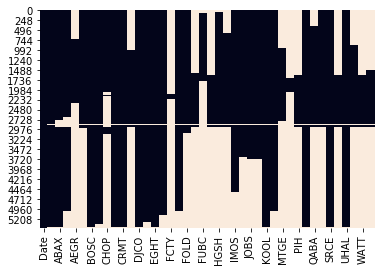

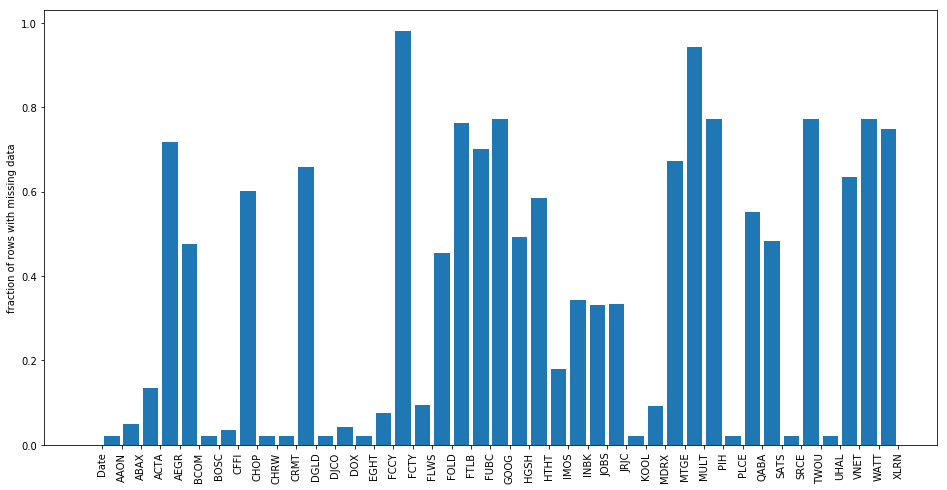

In [8]:
#%% Visualize null-values for Instruments

# Assess the number of null values

instrumentsReturns.isnull().sum()

# The heat map show correlated null-values across the data - meaning that all factors have null-values on the same dates. 
# It can be assumed that these dates are official hollidays, that apply to all factors.
sbn.heatmap(instrumentsReturns.isnull(), cbar=False)

# Number of null values accross instruments varies a lot. It would not be appropriate
# to fill based on the same strategy as the factors, therefore we will align the factors
# to run a model based on the available timeframe for each instrument
null_counts = instrumentsReturns.isnull().sum()/len(instrumentsReturns)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

In [9]:
#%% This align_dates function will be used to adapt the featuresReturns to 
# the available timeframe of each instrument

def align_dates(ins):
    
    A = instrumentsReturns[["Date",ins]]
    A = A.dropna()
    B = F
    
    X = pd.merge(A,B,on="Date")
    return X

# testing the function with one instrument
align_dates("SRCE")


,Date,SRCE,0,1,2,3,4,5,6,7,8,9,10,11
0,2008-02-01,-0.083008,1.093420e-04,0.000089,-3.255160e-04,0.002211,0.102258,0.097228,-0.134321,0.216845,0.010457,0.009453,-0.018042,0.047022
1,2008-03-01,-0.131482,-1.189335e-04,0.000077,-3.255160e-04,0.002211,-0.104430,0.093620,-0.134321,0.216845,-0.010906,0.008765,-0.018042,0.047022
2,2008-04-01,-0.098999,-1.028978e-03,-0.000413,-3.255160e-04,0.002211,-0.179102,-0.142523,-0.134321,0.216845,-0.032078,-0.020313,-0.018042,0.047022
3,2008-07-01,-0.000583,-1.026073e-03,-0.002831,-3.255160e-04,0.002211,-0.178976,-0.230674,-0.134321,0.216845,-0.032032,-0.053211,-0.018042,0.047022
4,2008-08-01,-0.092388,-2.123954e-03,-0.006887,-3.255160e-04,0.002211,-0.214677,-0.288082,-0.134321,0.216845,-0.046086,-0.082991,-0.018042,0.047022
5,2008-09-01,0.015700,-1.603250e-03,-0.006156,-3.255160e-04,0.002211,-0.200101,-0.280113,-0.134321,0.216845,-0.040041,-0.078463,-0.018042,0.047022
6,2008-10-01,0.033639,-2.807389e-03,-0.015902,-3.255160e-04,0.002211,-0.230184,-0.355112,-0.134321,0.216845,-0.052985,-0.126104,-0.018042,0.047022
7,2008-11-01,-0.020233,-7.044458e-04,-0.004926,-3.255160e-04,0.002211,-0.162915,-0.264920,-0.134321,0.216845,-0.026541,-0.070183,-0.018042,0.047022
8,2008-01-14,-0.034342,-2.689199e-04,-0.000111,-1.544630e-03,0.002170,-0.128058,-0.102642,-0.198247,0.215833,-0.016399,-0.010535,-0.039302,0.046584
9,2008-01-15,0.028296,-8.516724e-05,0.001100,-1.341994e-03,-0.000150,-0.096066,0.182124,-0.191398,-0.110600,-0.009229,0.033169,-0.036633,-0.012232


Run a linear regression based on 12 features on a specific instrument & generate parameters

In [10]:
#%%
#Training a linear regression model with our 4 features for each instrument and saving
# the coefficients and intercepts in lists to reuse later

from sklearn.linear_model import LinearRegression

def get_params(ins):
    
    X = align_dates(ins).drop(columns=["Date",ins],axis=0)
    y = align_dates(ins)[ins]
    
    lm= LinearRegression()

    lm.fit(X,y)
    coef = lm.coef_
    inter = lm.intercept_

    params = [coef,inter]
    return params


# testing the function with one instrument
get_params("SRCE")

[array([-5.02638157e+00, -2.61289468e-01, -1.53018450e+00,  3.03861571e-04,
        -4.70779706e-02,  9.09352179e-03, -3.78106361e-02, -3.73232593e-03,
         7.26923042e-01,  1.83756649e-01,  2.24994432e-01,  5.69032049e-04]),
 0.0018714128223544892]

# Generating random samples of factors

1) Generate random sample using a multivariate normal distribution & featurize <br>
2) Get the return for each instrument and the total trial portfolio


In [12]:
#%%
# Generating a random multivariate sample
#
##We could sample each factor independently but, in that case, we will be ignoring the
##correlation among the four factors. 
##We will use a multivariate normal distribution. To get sample values we just we can just use 
## numpy like this:
##f1, f2, f3, f4 = numpy.random.multivariate_normal(mean, cov)

instruments = ["PIH", "FLWS", "FCTY", "FCCY", "SRCE",
               "FUBC","VNET","TWOU","DGLD","JOBS"
               ,"EGHT","AAON","ABAX","XLRN","ACTA"
               ,"MULT","AEGR","MDRX","DOX"
               ,"UHAL","MTGE","CRMT","FOLD","BCOM"
               ,"BOSC","CFFI","CHRW","KOOL"
               ,"PLCE","JRJC","CHOP","HGSH"
               ,"HTHT","IMOS","DJCO","SATS"
               ,"WATT","INBK","FTLB","QABA","GOOG"]

factorsReturns_list = list((F1,F2,F3,F4))

cov = np.cov(factorsReturns_list)
mean = list((F1.mean(axis=0),F2.mean(axis=0),F3.mean(axis=0),F4.mean(axis=0)))

sample = np.random.multivariate_normal(mean, cov)

print("This is the covariance table")
print(cov)
print("This is the mean")
print(mean)
print("This is a sample set of factors")
print(sample)

This is the covariance table
[[ 6.09961525e-04  7.65201829e-04  4.09002896e-04 -2.14667229e-04]
 [ 7.65201829e-04  2.27816384e-03  4.42922411e-04  1.34484089e-03]
 [ 4.09002896e-04  4.42922411e-04  1.68635339e-03 -3.44917769e-04]
 [-2.14667229e-04  1.34484089e-03 -3.44917769e-04  5.77905278e-01]]
This is the mean
[0.0012812532561354993, 0.002265737893536122, 8.720901036985853e-05, 0.10179003856066367]
This is a sample set of factors
[ 0.02801023  0.01234278  0.03680024 -0.0773147 ]


In [20]:
#Approach in python to generate trials and store the returns in a list

def generate_trial(t,mean,cov):
    
    #creating an empty list to store the returns   
    trialReturns = []
    
    #creating a loop to go over t number of trials
    for i in range(0, t):
    
    #initializing the total portfolio return
        trial_portfolioReturn = 0
        
    #generating one sample of 4 factors
        trial_factorReturns = np.random.multivariate_normal(mean, cov)
        
    #featurizing sampled factors into 12 features
        trial_featuresReturns = get_features(trial_factorReturns)          

        instruments = ["WATT"]
    #creating a loop to generate return of 1 instrument  
        for ins in instruments:       
            
    #run linear model for specific instrument and applying coefs + intercept on the 
    #sampled features to get sampled return     
            trial_instrumentReturn = sum((get_params(ins)[0] * trial_featuresReturns) + get_params(ins)[1])  

            trial_portfolioReturn += trial_instrumentReturn*(1/(len(instruments))) 
            
        trialReturns.append(trial_portfolioReturn)
        
    return trialReturns

test = generate_trial(5,mean,cov)
print(test)

[0.0031857029522668195, 0.02324780526771693, -0.012862015183780745, -0.0022335182267895215, 0.014232819974422412]


Calculation of the VaR based on the generated trials

In [21]:
def fivePercentVaR(trials):
    numTrials = len(trials)

    fivePercent = max(round(numTrials/20.0), 1)

    trials.sort()

    fivePercentWorst = trials[0:fivePercent]
    return fivePercentWorst[-1]

fivePercentVaR(test)

-0.012862015183780745

# Adapting the approach for Spark

For simplicity purposes we will rewrite the generate_trials function in order 
to take the coefficients and intercepts from csv files instead of generating them
inside of the function

In [64]:

#First we need to create csv files containing the coefficients and intercepts

coef = []
inter = []

for ins in instruments:
    
    coef.append(get_params(ins)[0])
    inter.append(get_params(ins)[1])

coefs = pd.DataFrame(coef)    
export_csv = coefs.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\coefs.csv", index = None, header=False)

inter = pd.DataFrame(inter)    
export_csv = inter.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\inter.csv", index = None, header=False)  

#We need to create csv with cov and mean 

cov = np.cov(factorsReturns_list)
cov = pd.DataFrame(cov)
export_csv = cov.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\cov.csv", index = None, header=False) 

mean = list((F1.mean(axis=0),F2.mean(axis=0),F3.mean(axis=0),F4.mean(axis=0)))
mean = pd.DataFrame(mean)
export_csv = mean.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\mean.csv", index = None, header=False)

#Now we need to modify our generate_trials function in order to use the params 
#from the csv files



In [12]:
def generate_trial(t,mean,cov,coefs,inter):
    
    #creating an empty list to store the returns
    
    trialReturns = []
    
    #creating a loop to go over t number of trials

    for i in range(0, t): 
         
    #initializing the total portfolio return
            
            trial_portfolioReturn = 0
            
    #generating one sample of 4 factors
            
            trial_factorReturns = np.random.multivariate_normal(mean, cov)
            
    #featurizing sampled factors into 12 features
    
            trial_featuresReturns = get_features(trial_factorReturns)
            
    #run linear model for specific instrument and applying coefs + intercept on the 
    #sampled features to get sampled return
            
            for k in range(len(coefs)):
            
                trial_instrumentReturn = sum([coefs[k][i] * trial_featuresReturns[i] for i in range(len(trial_featuresReturns))]) + inter[k]
    
            trial_portfolioReturn += trial_instrumentReturn
        
            trialReturns.append(trial_portfolioReturn)
    
    return trialReturns

parallelism = 2
t = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)

trials = seedRDD.flatMap(lambda idx: \
                generate_trial(
                    max(int(t/parallelism), 1), 
                    mean.value, cov.value,
                    coefs.value,inter.value
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)

print ("Value at Risk(VaR) 5%:", valueAtRisk)


#VaR Calculation

def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

NameError: name 'sc' is not defined